In [1]:
from IPython.display import clear_output
import pyrealsense2 as rs
import numpy as np
import cv2
from IPython.display import Image
from PIL import Image as PILImage
import io
import time
import sys
from unitree_sdk2py.core.channel import ChannelSubscriber, ChannelFactoryInitialize
from unitree_sdk2py.idl.default import unitree_go_msg_dds__SportModeState_
from unitree_sdk2py.idl.unitree_go.msg.dds_ import SportModeState_
from unitree_sdk2py.go2.video.video_client import VideoClient
from unitree_sdk2py.go2.sport.sport_client import (
    SportClient,
    PathPoint,
    SPORT_PATH_POINT_SIZE,
)
from unitree_sdk2py.go2.obstacles_avoid.obstacles_avoid_client import ObstaclesAvoidClient
import math
from dataclasses import dataclass
import matplotlib.pyplot as plt

%matplotlib inline

## get camera feed from both the cameras (default camera and add on) side by side

In [2]:
# setup for default camera
ChannelFactoryInitialize(0,"eth0")
client = VideoClient()
client.SetTimeout(1.0)
client.Init()


In [3]:
# setup for add on camera
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 1920, 1080, rs.format.bgr8, 30)
Object_colors = list(np.random.rand(80,3)*255)
# Start pipeline
pipeline.start(config)

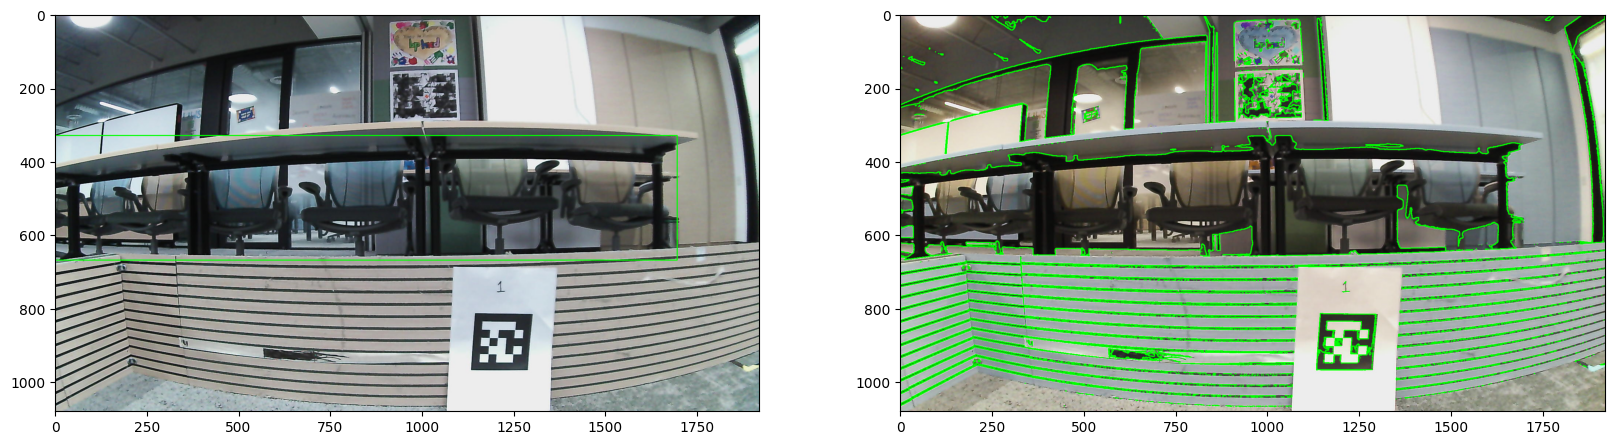

KeyboardInterrupt: 

In [12]:
while True:
    # feed from default camera
    code,data = client.GetImageSample()
    img_1 = np.frombuffer(bytes(data), dtype=np.uint8)
    image_1 = cv2.imdecode(img_1, cv2.IMREAD_COLOR)
    image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)

     # Wait for a frame from the RealSense camera
    frames = pipeline.wait_for_frames()
    color_frame = frames.get_color_frame()
    image_2 = np.asanyarray(color_frame.get_data())
    image_2_rgb = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

    clear_output(wait=True)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,12))
    # fig.
    ax[0].imshow(image_1_rgb)
    ax[1].imshow(image_1)
    plt.show()
    time.sleep(2)
    

In [5]:
import pyrealsense2 as rs
import numpy as np
import cv2

# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

try:
    while True:

        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        depth_frame = frames.get_depth_frame()
        color_frame = frames.get_color_frame()
        if not depth_frame or not color_frame:
            continue

        # Convert images to numpy arrays
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())

        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)

        depth_colormap_dim = depth_colormap.shape
        color_colormap_dim = color_image.shape

        # If depth and color resolutions are different, resize color image to match depth image for display
        if depth_colormap_dim != color_colormap_dim:
            resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
            images = np.hstack((resized_color_image, depth_colormap))
        else:
            images = np.hstack((color_image, depth_colormap))

        # Show images
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', images)
        cv2.waitKey(1)

finally:

    # Stop streaming
    pipeline.stop()

KeyboardInterrupt: 

# Code to detect and track an object. It returns if the object is inside the boundry rectangle or not.

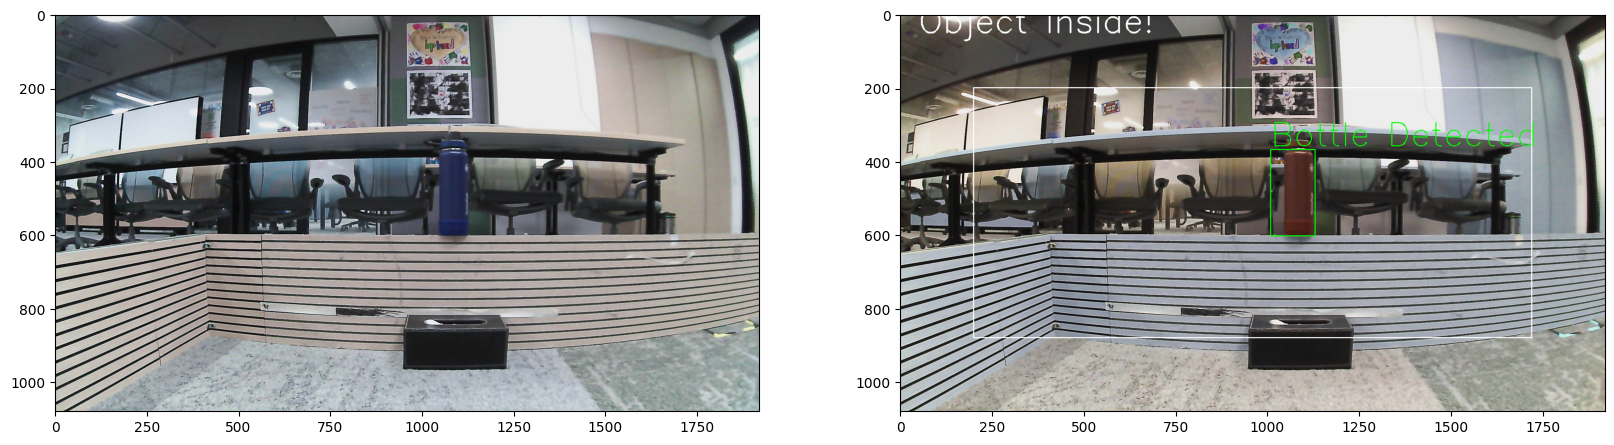

Object inside


In [ ]:
while True:
    # feed from default camera
    
    code,data = client.GetImageSample()
    img_1 = np.frombuffer(bytes(data), dtype=np.uint8)
    image_1 = cv2.imdecode(img_1, cv2.IMREAD_COLOR)
    image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
    
    image_1_gray = gray = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)  # Invert for black detection
    
    # define range of blue color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])
    
    def detect_coke_can(frame):
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
        # Create masks for red and silver
        # mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
        # mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)
        # mask_silver = cv2.inRange(hsv, lower_silver, upper_silver)
        mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
        # Combine red masks
        # mask_red = cv2.bitwise_or(mask_red1, mask_red2)
    
        # Merge red and silver masks
        # combined_mask = cv2.bitwise_or(mask_red, mask_silver)
    
        # Find contours
        contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
        if contours:
            # Find largest contour (assuming it's the can)
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Get bounding box
            x, y, w, h = cv2.boundingRect(largest_contour)
            bounding_box = (x, y, w, h)
            # Draw bounding box and label
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, "Bottle Detected", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 2)
    
        return frame, bounding_box
    # Get frame dimensions
    height, width, _ = image_1.shape
    
    # Define white rectangle (200 pixels from each side)
    margin = 200
    rect_x1, rect_y1 = margin, margin
    rect_x2, rect_y2 = width - margin, height - margin
    
    detected_image, bounding_box = detect_coke_can(image_1)
    
    cv2.rectangle(image_1, (rect_x1, rect_y1), (rect_x2, rect_y2), (255, 255, 255), 2)
    
    # Check if any edge of the object is outside the rectangle
    if bounding_box:
        x, y, w, h = bounding_box
        if x < rect_x1 or (x + w) > rect_x2 or y < rect_y1 or (y + h) > rect_y2:
            cv2.putText(detected_image, "Object Outside!", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 3)
            print("Warning: Object is outside the safe area!")
        else:
            cv2.putText(detected_image, "Object Inside!", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 3)
            print("Object inside")
    clear_output(wait=True)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,12))
    # fig.
    ax[0].imshow(image_1_rgb)
    ax[1].imshow(detected_image)
    plt.show()
    time.sleep(0.2)